## Load required modules.

In [1]:
%matplotlib widget
# Import ncessary modules.
from sklearn.decomposition import PCA
import xlrd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import ipywidgets 
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from matplotlib import pyplot
from IPython.display import display, clear_output, Javascript
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.pipeline import Pipeline
import gc
import psutil

#from memory_profiler import memory_usage

def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 2)

## Read EXCEL data file into data frame.

In [2]:
memory_0 = get_memory_usage()

# File path to your Excel file.
file_path = 'Geochemistry Results-AGG reduced variables.xlsx'

# Define the sheet name to read.
sheet_name = 'Litogeochemistry - clean'

df = pd.read_excel(file_path, sheet_name=sheet_name)

lithologies = df['Lithology'].unique()

lithology_dropdown = widgets.SelectMultiple(
    options=lithologies,
    value = []
)

output = widgets.Output()

def filter_dataframe(change):
    global filtered_df
    selected = change['new']
    with output:
        clear_output(wait=True)
        filtered_df = df[df.iloc[:, 3].isin(selected)]
        display(filtered_df)

lithology_dropdown.observe(filter_dataframe, 'value')


print ("Hold command to deselect, or command A to select all")
display(lithology_dropdown)
display(output)

print(f"Initial Memory Usage: {memory_0:.2f} MB")

Hold command to deselect, or command A to select all


SelectMultiple(options=('Di-Tr dolomitic marble', 'Dolomitic marble', 'Calcitic marble', 'Pure Siliciclastic',…

Output()

Initial Memory Usage: 222.16 MB


In [4]:
proceed_button = widgets.Button(description="Proceed")

def on_proceed_button_clicked(b):
    b.description = "Proceeding..."
    b.disabled = False
    Javascript("Jupyter.notebook.execute_cells()")

proceed_button.on_click(on_proceed_button_clicked)
display(proceed_button)

filtered_df.head()

Button(description='Proceed', style=ButtonStyle())

,Sample Description,Year,Depth(meters),Lithology,Shape,Comment,PTS,Al2O3_pct,BaO_pct,CaO_pct,...,Cd_ppm,Co_ppm,Cu_ppm,Li_ppm,Mo_ppm,Ni_ppm,Pb_ppm,Zn_ppm,C_pct,S_pct
0,S10-01,2022,4.44,Di-Tr dolomitic marble,Marble Units,NaN,No,0.73,0.02,26.7,...,0.25,4.0,10,20,1.0,6.0,4,27,7.22,0.23
1,S10-02,2022,14.49,Dolomitic marble,Marble Units,NaN,No,0.68,0.08,30.3,...,0.25,2.0,9,20,1.0,5.0,6,22,9.99,0.75
2,S10-03,2022,15.74,Dolomitic marble,Marble Units,NaN,No,0.56,0.01,29.4,...,0.25,1.0,5,10,1.0,4.0,3,23,10.55,0.58
3,S10-04,2022,26.80,Calcitic marble,Marble Units,NaN,Yes,0.92,0.04,37.0,...,0.25,0.5,4,20,1.0,3.0,10,31,7.76,0.26
4,S10-05,2022,27.02,Calcitic marble,Marble Units,NaN,Yes,3.18,0.08,35.4,...,0.25,3.0,9,10,1.0,7.0,4,13,7.79,1.22


In [5]:
filtered_df.shape

(71, 66)

## Remove symbols "<" and "NaN".

In [6]:
df = filtered_df.iloc[: , 7:].replace('\<','',regex=True).astype(float)
df = df[np.isfinite(df).all(1)].dropna()
df.head()

memory_0_1 = get_memory_usage()
print(f"Memory Usage After Filter: {memory_0_1:.2f} MB")

Memory Usage After Filter: 464.97 MB


In [7]:
df.shape

(71, 59)

## Scale data and apply PCA.

In [8]:
from sklearn.preprocessing import FunctionTransformer

# Scale data before applying PCA
scaling=StandardScaler()
#scaling = FunctionTransformer(np.log1p, validate=True)

try:
    # Use fit and transform method 
    scaling.fit(df)
    Scaled_data=scaling.transform(df)
     
    # Set the n_components=3
    pca=PCA(n_components=6)
    pca.fit(Scaled_data)
    x=pca.transform(Scaled_data)
     
    # Check the dimensions of data after PCA
    print(x.shape)
except:
    raise ValueError ('Not enough components for PCA. Please select more!')
    

(71, 6)


## Create a datafram for PCA componenets and scale it.

In [9]:
# Create dataframe
pca_df = pd.DataFrame(
    data=x, 
    #columns=['PC1', 'PC2', 'PC3'])
    columns=['PC'+str(i) for i in range(1, len(pca.components_)+1)])
pca_df
print(len(pca_df.columns))

6


In [10]:
# Create the scaled PCA dataframe
pca_df_scaled = pca_df.copy()
  
scaler_df = pca_df[pca_df.columns]
scaler = 1 / (scaler_df.max() - scaler_df.min())
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

memory_0_2 = get_memory_usage()
print(f"Memory Usage After PCA: {memory_0_2:.2f} MB")

Memory Usage After PCA: 465.94 MB


## Display loadings.

In [11]:
#loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=df.columns)
loadings = pd.DataFrame(pca.components_.T, columns=['PC'+str(i) for i in range(1, len(pca.components_)+1)], index=df.columns)

memory_0_3 = get_memory_usage()
print(f"Memory Usage After loadings: {memory_0_3:.2f} MB")

loadings

Memory Usage After loadings: 465.97 MB


,PC1,PC2,PC3,PC4,PC5,PC6
Al2O3_pct,0.170090,0.223306,-0.002179,0.026547,-0.079090,0.001999
BaO_pct,0.041939,0.036247,0.073496,-0.119043,0.213327,-0.120442
CaO_pct,-0.091265,-0.078927,-0.160680,0.147168,0.114863,-0.128228
Fe2O3_pct,0.155220,-0.123181,0.124767,-0.071304,-0.170025,-0.131980
K2O_pct,0.139800,0.228320,0.053704,-0.053972,-0.092323,0.058410
MgO_pct,-0.036555,0.038949,0.027565,-0.022257,-0.071647,0.284022
MnO_pct,0.066477,-0.209390,0.086197,-0.115722,-0.106457,0.188320
Na2O_pct,0.143034,0.002274,0.036522,-0.000163,0.081829,-0.213850
P2O5_pct,0.053320,-0.096097,0.045516,0.023033,-0.103903,-0.264019
SiO2_pct,0.005486,0.218050,0.050265,-0.092213,0.130547,-0.102481


## Display sorted loadings.

In [12]:
# sorted_loadings = loadings.sort_values(by='PC1', ascending=False)  # Change 'ascending' as needed
# sorted_loadings

In [13]:
# sorted_loadings = loadings.sort_values(by='PC2', ascending=False)  # Change 'ascending' as needed
# sorted_loadings

In [14]:
# sorted_loadings = loadings.sort_values(by='PC3', ascending=False)  # Change 'ascending' as needed
# sorted_loadings

interactive(children=(Checkbox(value=False, description='Sort'), Output()), _dom_classes=('widget-interact',))

Memory Usage After PCA bar: 454.52 MB


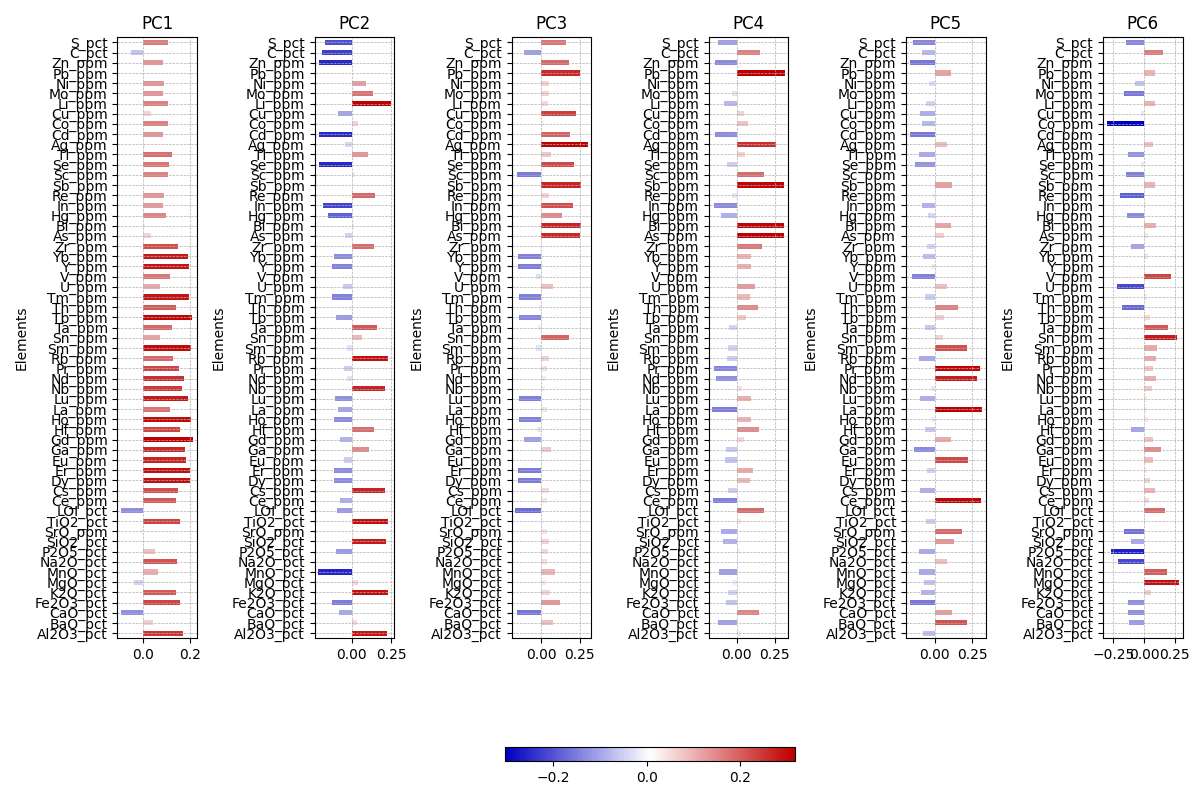

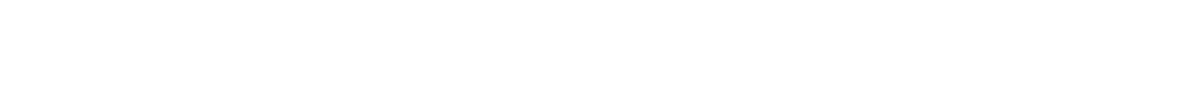

In [15]:
colors = [(0, 0, 0.75), (1, 1, 1), (0.75, 0, 0)]
n_bins = 100
cmap_name = "PC map"
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


def normalize(values, vmin=None, vmax=None):
    vmin = vmin if vmin is not None else np.min(values)
    vmax = vmax if vmax is not None else np.max(values)
    norm_values = (values - vmin) / (vmax - vmin)
    return norm_values


def plot_pc_barchart(data, pc_name, ax, sort=False):
    if sort:
        data = data.sort_values(ascending=False)
    #colors = ['#1f77b4' if x > 0 else '#d62728' for x in sorted_loadings]
    norm_values = normalize(data, vmin=-max(abs(data)), vmax=max(abs(data)))
    bar_colors = cm(norm_values)
    data.plot(kind='barh', color=bar_colors, ax=ax)
    ax.set_title(pc_name)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('Elements')


def update_plots(sort):
    plt.close('all')
    fig, axes = plt.subplots(ncols=len(pca_df.columns), figsize=(12, 8))

    for i in range (len(pca_df.columns)):
        plot_pc_barchart(loadings[f'PC{i+1}'], f'PC{i+1}', axes[i], sort)

    plt.tight_layout()

    fig_c = plt.figure(figsize=(12, 1))

    min_val = loadings.min().min()
    max_val = loadings.max().max()

    norm = plt.Normalize(vmin=min_val, vmax=max_val)
    cbar = fig_c.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cm), ax = axes, orientation='horizontal', fraction = 0.02)


interact(update_plots, sort=widgets.Checkbox(value=False, description='Sort'))

plt.tight_layout()

memory_0_4 = get_memory_usage()
print(f"Memory Usage After PCA bar: {memory_0_4:.2f} MB")

## Plot a 3D scatter plot with arrows for PCA directions.

In [16]:

dc = filtered_df['Lithology']

dc = dc.to_frame()
dc = dc.rename(columns={dc.columns[0]: 'Lithology'})

color_list = dc['Lithology'].unique()

default_colors = ["lime", "blue", "cyan", "deeppink", "pink", "black", "black", "black", "grey", "lightgrey"]

color_map = {}

# Populate the dictionary with symbols for each shape
for i, color in enumerate(color_list):
    if i < len(default_colors):
        color_map[color] = default_colors[i]


# color_map = {
#     'Calcitic marble': 'lime',
#     'Dolomitic marble': 'blue',
#     'Di-Tr dolomitic marble': 'cyan',
#     'Carbonatite': 'deeppink',
#     'Carbonatite-like': 'pink',
#     'Syenite': 'black',
#     'Altered Syenite': 'black',
#     'Syenite-like': 'black',
#     'Impure Siliciclastic': 'grey',
#     'Pure Siliciclastic': 'lightgrey'
# }

dc['Color'] = dc['Lithology'].map(color_map)

dc=dc.replace('\<','NaN',regex=True)
dc = dc.dropna()

print(dc)
#print (pca_df_scaled)
print("Shape of y:", dc.shape)
#print("Shape of X:", X.shape)


                  Lithology Color
0    Di-Tr dolomitic marble  lime
1          Dolomitic marble  blue
2          Dolomitic marble  blue
3           Calcitic marble  cyan
4           Calcitic marble  cyan
..                      ...   ...
96   Di-Tr dolomitic marble  lime
97   Di-Tr dolomitic marble  lime
100  Di-Tr dolomitic marble  lime
101        Dolomitic marble  blue
102        Dolomitic marble  blue

[71 rows x 2 columns]
Shape of y: (71, 2)


In [17]:
ds = filtered_df.iloc[:, 4]
ds = ds.to_frame()
ds = ds.rename(columns={ds.columns[0]: 'Shape'})

shape_list = ds['Shape'].unique()

default_symbols = ["^", "*", "o", "s", "D"]

color_map1 = {}

# Populate the dictionary with symbols for each shape
for i, shape in enumerate(shape_list):
    if i < len(default_symbols):
        color_map1[shape] = default_symbols[i]

# color_map1 = {
#     'Marble Units': "^",
#     'Altered Intrusion': "*",
#     'Siliciclastic': "o",
#     'Intrusion': "s",
#     'Anamolous Rock': "D",
# }

ds["Shapes"] = ds["Shape"].map(color_map1)

ds=ds.replace('\<','NaN',regex=True)
ds = ds.dropna()

print(ds)
#print (pca_df_scaled)
print("Shape of y:", ds.shape)
#print("Shape of X:", X.shape)

memory_0_5 = get_memory_usage()
print(f"Memory Usage After ds dc: {memory_0_5:.2f} MB")

            Shape Shapes
0    Marble Units      ^
1    Marble Units      ^
2    Marble Units      ^
3    Marble Units      ^
4    Marble Units      ^
..            ...    ...
96   Marble Units      ^
97   Marble Units      ^
100  Marble Units      ^
101  Marble Units      ^
102  Marble Units      ^

[71 rows x 2 columns]
Shape of y: (71, 2)
Memory Usage After ds dc: 498.44 MB


interactive(children=(Checkbox(value=False, description='Show_Shape'), Output()), _dom_classes=('widget-intera…

interactive(children=(Dropdown(description='Legend', options=(('Shapes Legend', True), ('Lithology Legend', Fa…

interactive(children=(Checkbox(value=False, description='Show all Names'), Output()), _dom_classes=('widget-in…

interactive(children=(Checkbox(value=False, description='Show all Arrows'), Output()), _dom_classes=('widget-i…

Press Command to Select Multiple


SelectMultiple(description='Select multiple items:', options=('Al2O3_pct', 'BaO_pct', 'CaO_pct', 'Fe2O3_pct', …

Memory Usage initial 3d: 313.81 MB
Memory Usage After 3d Plot: 317.56 MB
Memory Usage After Deletion: 481.92 MB


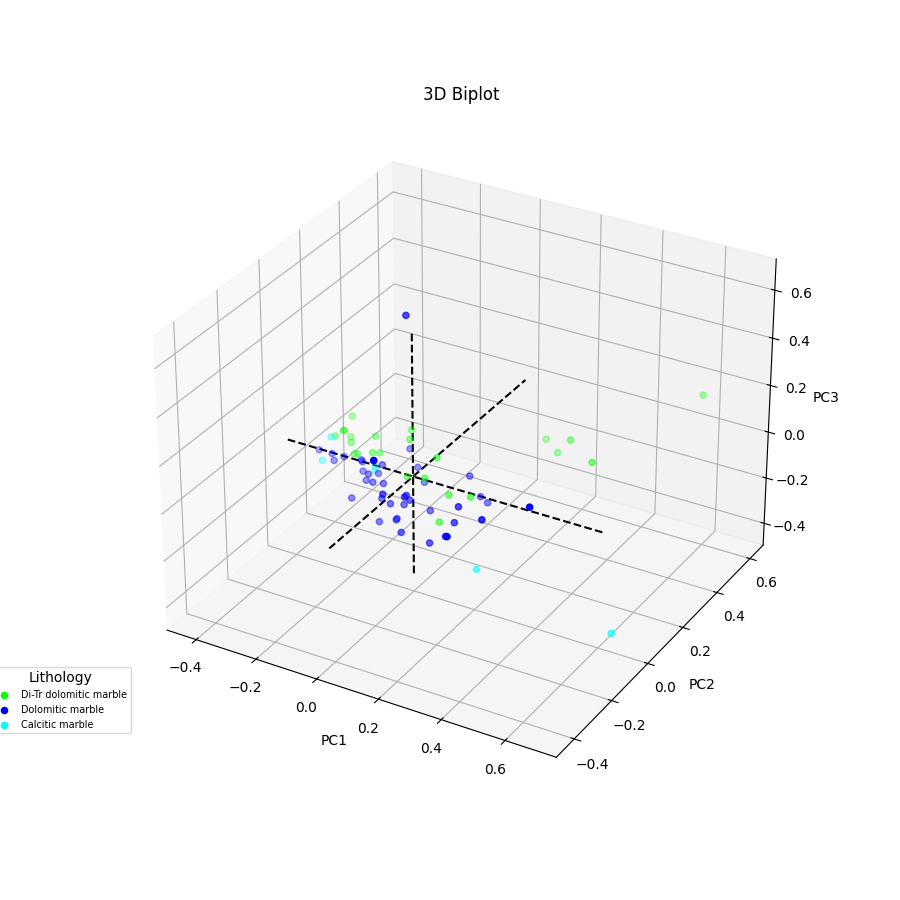

In [21]:
memory_1 = get_memory_usage()

# Initialize the 3D graph
plt.close('all')
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
  
# Define scaled features as arrays
xdata = pca_df_scaled['PC1']
ydata = pca_df_scaled['PC2']
zdata = pca_df_scaled['PC3']

# Plot 3D scatterplot of PCA

#df = pd.read_excel(file_path, sheet_name=sheet_name)
#description = df.iloc[:, 0]

#descriptions = []
dc.reset_index(drop=True, inplace=True)
ds.reset_index(drop=True, inplace=True)


#show shape
shapes1 = []
for i in range(len(filtered_df)):
    #print(f"Index {i}: Color {dc['Color'][i]}, Shape {ds['Shapes'][i]}")  # Debug print
    shape1 = ax.scatter3D(xdata[i], ydata[i], zdata[i], c=dc['Color'][i], marker=ds["Shapes"][i])
    shapes1.append(shape1)
    #text = ax.text(xdata[i], ydata[i], zdata[i], description[i], size=10, zorder=1, color='k')
    #descriptions.append(text)

dots = ax.scatter3D(xdata, ydata, zdata, c=dc['Color'])
dots.set_visible(True)

def shape(Show_Shape):
    if Show_Shape:
        for shape1 in shapes1:
            shape1.set_visible(True)  
        dots.set_visible(False) 
    else:
        dots.set_visible(True)
        for shape1 in shapes1:
            shape1.set_visible(False)

interact(shape, Show_Shape=False)


#legend
handle1 = []
label1 = []
for lithology, color in color_map.items():
    l1 = ax.scatter([], [], c=color, label=lithology)
    handle1.append(l1)
    label1.append(lithology)

handle2 = []
label2 = []
for shape, shapes in color_map1.items():
    l2 = ax.scatter([], [], c="black", marker=shapes, label=shape)
    handle2.append(l2)
    label2.append(shape)

legend1 = pyplot.legend(handle1, label1, bbox_to_anchor=(0.03, 0.2), title='Lithology', fontsize='x-small')
legend2 = pyplot.legend(handle2, label2, bbox_to_anchor=(0.03, 0.2), title='Shapes', fontsize='x-small')
ax.add_artist(legend1)
ax.add_artist(legend2)

def legenda(Legend):
    if Legend:
        legend1.set_visible(True)  
        legend2.set_visible(False)
    else:
        legend1.set_visible(False)
        legend2.set_visible(True)
interact(legenda, Legend=[('Shapes Legend', True),('Lithology Legend', False)])


#loadings
show_names=df.columns.tolist()
indx=df.columns.get_indexer(show_names)
scale=2

# Define the x, y, z variables
loadings_1 = pca.components_
xs = scale*loadings_1[0]
ys = scale*loadings_1[1]
zs = scale*loadings_1[2]  
# Plot title of graph
plt.title(f'3D Biplot')
  
# Plot x, y, z labels
ax.set_xlabel('PC1')#, rotation=150)
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')#, rotation=60)
#plt.savefig('3D_biplot.svg')



# Plot the arrows
arrow_list = []
x_arr = np.zeros(len(loadings_1[0]))
y_arr = z_arr = x_arr

#show_arrows = ax.quiver(x_arr[indx], y_arr[indx], z_arr[indx], xs[indx], ys[indx], zs[indx],color='r')
for i, name in enumerate(df.columns):
    ip = df.columns.get_loc(name)
    arrow = ax.quiver(x_arr[ip], y_arr[ip], z_arr[ip], xs[ip], ys[ip], zs[ip], color='r', arrow_length_ratio = 0.1, linewidth=0.5)
    arrow_list.append(arrow)
    
def findarrow(change):
    if change: 
        for a in arrow_list:
            a.set_visible(True)
    else:
        for a in arrow_list:
            a.set_visible(False)


#axis
all_points = np.concatenate((xs, ys, zs))
min_value = np.min(all_points)
max_value = np.max(all_points)

axis_range = [min_value, max_value]

ax.plot([x_arr.any() + axis_range[0], x_arr.any() + axis_range[1]], [y_arr.any(), y_arr.any()], [z_arr.any(), z_arr.any()], color='k', linestyle='--')
ax.plot([x_arr.any(), x_arr.any()], [y_arr.any() + axis_range[0], y_arr.any() + axis_range[1]], [z_arr.any(), z_arr.any()], color='k', linestyle='--') 
ax.plot([x_arr.any(), x_arr.any()], [y_arr.any(), y_arr.any()], [z_arr.any() + axis_range[0], z_arr.any() + axis_range[1]], color='k', linestyle='--')




# Plot the loadings
namelist = []

for i , names in enumerate(show_names):
    ip=indx[i]
    #ax.scatter(xs[ip], ys[ip], zs[ip], s=100)
    n = ax.text(xs[ip]+0.02, ys[ip]+0.02, zs[ip]+0.02, names, fontsize='small')
    namelist.append(n)

show_name_checkbox = widgets.Checkbox(value=False, description='Show all Names')
all_arrow_checkbox = widgets.Checkbox(value=False, description='Show all Arrows')

def findname(show_name):
    if show_name:
        for n in namelist:
            n.set_visible(True)  
    else:
        for n in namelist:
            n.set_visible(False)


#multiselect
def findname_specific(change):
    selected_items = change['new']
    # if 'all' in selected_items:
    #     select_multiple.value = options
    #     for n in namelist:
    #         n.set_visible(True)
    #     for arrow in arrow_list:
    #         arrow.set_visible(True)
    # else:
    for i in range(len(options[1:])):  
        if options[i] in selected_items:
            namelist[i].set_visible(True)
            arrow_list[i].set_visible(True)
        else:
            namelist[i].set_visible(False)
            arrow_list[i].set_visible(False)
    show_name_checkbox.value = False
    all_arrow_checkbox.value = False
plt.draw()

interact(findname, show_name=show_name_checkbox)
interact(findarrow, change=all_arrow_checkbox)

options = df.columns.tolist()

select_multiple = widgets.SelectMultiple(
    options=options,
    value=[],
    description='Select multiple items:'
)
select_multiple.observe(findname_specific, 'value')
print ('Press Command to Select Multiple')

display(select_multiple)


#memory
memory_2 = get_memory_usage()
gc.collect()
memory_3 = get_memory_usage()

print(f"Memory Usage initial 3d: {memory_1:.2f} MB")
print(f"Memory Usage After 3d Plot: {memory_2:.2f} MB")
print(f"Memory Usage After Deletion: {memory_3:.2f} MB")


In [ ]:
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline
# try:
#     y = dc['Lithology']
#     y = y.values.ravel()
#     X = pca_df_scaled
#     print("Shape of y:", y.shape)
#     print("Shape of X:", X.shape)
    
#     clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#     clf.fit(X, y)
    
#     print(clf.predict([[0.3, -0.01, 0.1]]))
# except:
#     print ("need more litho group")

# memory_4 = get_memory_usage()
# print(f"Memory Usage After predict: {memory_4:.2f} MB")

interactive(children=(Dropdown(description='options', options=(('PC1 vs PC2', ['PC1', 'PC2', 0, 1]), ('PC1 vs …

Memory Usage After 2d PC: 523.25 MB


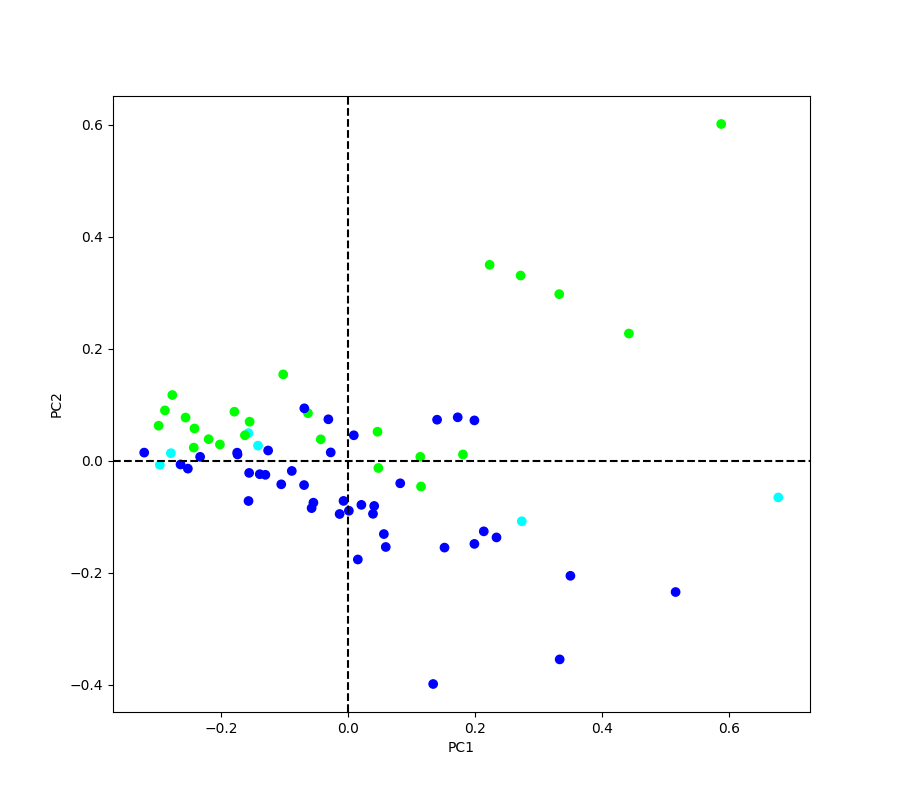

In [19]:
fig_2d = plt.figure(figsize=(9,8))

# handle1 = []
# label1 = []
# for lithology, color in color_map.items():
#     l1 = ax.scatter([], [], c=color, label=lithology)
#     handle1.append(l1)
#     label1.append(lithology)

# handle2 = []
# label2 = []
# for shape, shapes in color_map1.items():
#     l2 = ax.scatter([], [], c="black", marker=shapes, label=shape)
#     handle2.append(l2)
#     label2.append(shape)
    
# fig_2d.add_artist(legend1)
# fig_2d.add_artist(legend2)


# def legenda(Legend):
#     if Legend:
#         legend1.set_visible(True)  
#         legend2.set_visible(False)
#     else:
#         legend1.set_visible(False)
#         legend2.set_visible(True)
# interact(legenda, Legend=[('Shapes Legend', True),('Lithology Legend', False)])

def planes (options):
    plt.clf()
    xdata = pca_df_scaled[options[0]]
    ydata = pca_df_scaled[options[1]]
    
    shapes2 = []
    for i in range(len(df)):
        shape2 = plt.scatter(xdata[i], ydata[i], c=dc['Color'][i], marker=ds["Shapes"][i])
        shapes2.append(shape2)
    
    dots2 = plt.scatter(xdata, ydata, c=dc['Color'])
    dots2.set_visible(True)
    
    def shape(Show_Shape):
        if Show_Shape:
            for shape2 in shapes2:
                shape2.set_visible(True)  
            dots2.set_visible(False) 
        else:
            dots2.set_visible(True)
            for shape2 in shapes2:
                shape2.set_visible(False)
    
    interact(shape, Show_Shape=False)
    
    
    show_names=df.columns.tolist()
    indx=df.columns.get_indexer(show_names)
    
    
    loadings = pca.components_
    xs = loadings[options[2]]
    ys = loadings[options[3]]
    
    
    #Plot the arrows
    arrow_list_2d = []
    
    x_arr = np.zeros(len(loadings[0]))
    y_arr = x_arr

    plt.axhline(y=y_arr.any(), color='k', linestyle='--')
    plt.axvline(x=x_arr.any(), color='k', linestyle='--')
    
    arrow_scale=0.7
    for i, name in enumerate(df.columns):
        ip = df.columns.get_loc(name)
        arrow_2d = plt.quiver(x_arr[ip], y_arr[ip], xs[ip], ys[ip], color='r', scale = arrow_scale, width = 0.003)
        arrow_list_2d.append(arrow_2d)
        
    namelist_2d = []
    for i , names in enumerate(show_names):
        ip=indx[i]
        #ax.scatter(xs[ip], ys[ip], zs[ip], s=100)
        n = plt.text((1.7)*xs[ip], (1.7)*ys[ip], names, fontsize='small')
        #n = plt.text(xs[ip], ys[ip], names, fontsize='small')
        namelist_2d.append(n)

    def findname_2d(show_name):
        if show_name:
            for n in namelist_2d:
                n.set_visible(True)  
        else:
            for n in namelist_2d:
                n.set_visible(False)
        
    def findarrow_2d(Visibility_arrow):
        if Visibility_arrow: 
            for a in arrow_list_2d:
                a.set_visible(True)
        else:
            for a in arrow_list_2d:
                a.set_visible(False)

    
    show_name_checkbox = widgets.Checkbox(value=False, description='Show all Names')
    all_arrow_checkbox = widgets.Checkbox(value=False, description='Show all Arrows')
    
    
    def findname_specific_2d(change):
        selected_items = change['new']
        for i in range(len(options_ele[1:])): 
            if options_ele[i] in selected_items:
                namelist_2d[i].set_visible(True)
                arrow_list_2d[i].set_visible(True)
            else:
                namelist_2d[i].set_visible(False)
                arrow_list_2d[i].set_visible(False)
        show_name_checkbox.value = False
        all_arrow_checkbox.value = False
    plt.draw()
    
    interact(findname_2d, show_name=show_name_checkbox)
    interact(findarrow_2d, Visibility_arrow=all_arrow_checkbox)
    
    options_ele = df.columns.tolist()
    
    select_multiple = widgets.SelectMultiple(
        options=options_ele,
        value=[],
        description='Select multiple items:'
    )
    select_multiple.observe(findname_specific_2d, 'value')
    print ('Press Command to Select Multiple')
    
    display(select_multiple)
    plt.xlabel(options[0])
    plt.ylabel(options[1])

widgets.interact(planes, options = [('PC1 vs PC2', ['PC1', 'PC2', 0, 1]), ('PC1 vs PC3', ['PC1', 'PC3', 0, 2]), ('PC1 vs PC4', ['PC1', 'PC4', 0, 3]), ('PC1 vs PC6', ['PC1', 'PC6', 0, 5]), ('PC2 vs PC3', ['PC2', 'PC3', 1, 2]), ('PC2 vs PC2', ['PC2', 'PC2', 1, 1])])

memory_5 = get_memory_usage()

print(f"Memory Usage After 2d PC: {memory_5:.2f} MB")

In [ ]:
# # import relevant libraries for 3d graph
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(10,10))
 
# # choose projection 3d for creating a 3d graph
# axis = fig.add_subplot(111, projection='3d')
 
# # x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
# img=axis.scatter(x[:,0],x[:,1],x[:,2], c=df['Zn_ppm'])

# # Plot the loadings
# for i in range(5):
#     axis.scatter(xs[i], ys[i], zs[i], s=200)
#     #axis.text(
#     #    xs[i] + 0.1, 
#     #    ys[i] + 0.1, 
#     #    zs[i] + 0.1, 
#     #    varnames)
  
# # Plot the arrows
# x_arr = np.zeros(len(loadings[0]))
# y_arr = z_arr = x_arr
# axis.quiver(x_arr, y_arr, z_arr, xs, ys, zs)

# axis.set_xlabel("PC1")
# axis.set_ylabel("PC2")
# axis.set_zlabel("PC3")
# fig.colorbar(img)

In [ ]:
# Remove all rows that have at least one NaN.
df = df.dropna()

max_Zn = df['Zn_ppm'].max()
min_Zn = df['Zn_ppm'].min()

def cluster_2d(axis1, axis2):
    global df
    if axis1 != axis2:
        # Remove "<" from the values.
        df[axis1] = df[axis1].apply(lambda x: x.replace('<', '') if isinstance(x, str) and '<' in x else x)
        df[axis2] = df[axis2].apply(lambda x: x.replace('<', '') if isinstance(x, str) and '<' in x else x)
        
        # Change to "object" to "float".
        df[axis1] = df[axis1].astype(float)
        df[axis2] = df[axis2].astype(float)
        
        
        # Set the data for clustering
        X = df[[axis1, axis2]].values
        
        #scaler = StandardScaler()
        #X_scaled = scaler.fit_transform(X)
        dd = pd.read_excel(file_path, sheet_name=sheet_name)
        
        #scaler and model
        def update_kmeans(k=3):    
            pipe = Pipeline([
            ("scale", StandardScaler()),
            ("model", KMeans(n_clusters=k, random_state = 0, n_init='auto'))])
        
            pipe.fit(X)
        
            # Add cluster labels to the DataFrame
            df['cluster'] = pipe.named_steps['model'].labels_
        
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                 np.arange(y_min, y_max, 0.01))
        
            Z = pipe.named_steps['model'].predict(pipe.named_steps['scale'].transform(np.c_[xx.ravel(), yy.ravel()]))
            Z = Z.reshape(xx.shape)
        
            plt.figure(figsize=(9, 7))
            plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.2)
            
            def map_size(x, new_min, new_max):
                old_min = min_Zn
                old_max = max_Zn
                return ((np.log(x + 1) - np.log(old_min + 1)) / (np.log(old_max + 1) - np.log(old_min + 1))) * (new_max - new_min) + new_min
            
            sns.scatterplot(data=df, x=axis1, y=axis2, c=dc['Color'], s=df['Zn_ppm'].apply(lambda x: map_size(x, 20, 100)))
        
        
            df.apply(lambda row: plt.text(row[axis1], row[axis2] + 0.1, dd.iloc[row.name, 0], fontsize=7, ha='center'), axis=1)
        
        
            scaler = pipe.named_steps['scale']
            centroids = pipe.named_steps['model'].cluster_centers_
            centroids_original = scaler.inverse_transform(centroids)
        
            plt.scatter(centroids_original[:,0], centroids_original[:,1], 
                    marker="X", c="red", s=30, label="centroids")
            
            plt.legend()
            plt.title("K-Means Clustering")
            plt.show()
            
        interact(update_kmeans, k = IntSlider(min=2, max=10, step=1, description='N Clusters'))
    else:
        print ('select two different elements')

interact(cluster_2d, 
         axis1=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[32], description='Axis1'), 
         axis2=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[34], description='Axis2'))

memory_6 = get_memory_usage()
print(f"Memory Usage After 2d cluster: {memory_6:.2f} MB")


In [ ]:
# Remove all rows that have at least one NaN.
df = df.dropna()
dd = pd.read_excel(file_path, sheet_name=sheet_name)

def cluster_3d(axis1, axis2, axis3):
    global df
    if axis1 != axis2 != axis3:
        for col in [axis1, axis2, axis3]:
            df[col] = df[col].apply(lambda x: x.replace('<', '') if isinstance(x, str) and '<' in x else x)
            
        df = df.astype({axis1: 'float', axis2: 'float', axis3: 'float'})
        
        X = df[[axis1, axis2, axis3]].values
        
        #scaler = StandardScaler()
        #X_scaled = scaler.fit_transform(X)
        
        
        #scaler and model
        def update_kmeans(k=3):
            pipe = Pipeline([
                ("scale", StandardScaler()),
                ("model", KMeans(n_clusters=k, random_state=0, n_init='auto'))
            ])
            pipe.fit(X)
        
            df['cluster'] = pipe.named_steps['model'].labels_
        
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
        
            scatter = ax.scatter(df[axis1], df[axis2], df[axis3], c=df['cluster'], cmap='viridis', s=10)
            df.apply(lambda row: ax.text(row[axis1], row[axis2], row[axis3], dd.iloc[row.name, 0], fontsize=7, ha='center'), axis=1)
        
        
            # Plot the centroids
            scaler = pipe.named_steps['scale']
            centroids = pipe.named_steps['model'].cluster_centers_
            centroids_original = scaler.inverse_transform(centroids)
            
            ax.scatter(centroids_original[:, 0], centroids_original[:, 1], centroids_original[:, 2], 
                       marker="X", c="red", s=100, label="centroids")
        
            ax.set_xlabel(axis1)
            ax.set_ylabel(axis2)
            ax.set_zlabel(axis3)
            plt.legend()
            plt.title("3D K-Means Clustering")
            plt.show()
        
        interact(update_kmeans, k=IntSlider(min=2, max=10, step=1, description='N Clusters'))
    else:
        print ('select three different elements')

interact(cluster_3d, 
         axis1=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[0], description='Axis 1'), 
         axis2=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[2], description='Axis 2'), 
         axis3=widgets.Dropdown(options=df.columns.tolist(), value=df.columns[4], description='Axis 3'))


memory_7 = get_memory_usage()
print(f"Memory Usage After 3d cluster: {memory_7:.2f} MB")


In [ ]:
            
            # x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            # y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            # z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1
            # xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 50),
            #                          np.linspace(y_min, y_max, 50),
            #                          np.linspace(z_min, z_max, 50))
        
            # # Predict cluster labels for each point in the mesh grid
            # grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
            # grid_points_scaled = pipe.named_steps['scale'].transform(grid_points)
            # Z = pipe.named_steps['model'].predict(grid_points_scaled)
            # Z = Z.reshape(xx.shape)
        
            # ax.scatter(xx, yy, zz, c=Z, cmap='Pastel1', alpha=0.1)

In [ ]:
# Plot the distortion score elbow.
from yellowbrick.cluster import KElbowVisualizer

plt.figure(figsize=(10, 6))
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(1, 12)).fit(X)
visualizer.show()